In [1]:
ALGORITHM = 'KNN'
ALGORITHM_DETAIL = 'basic'
VERSION = '02'

RANDOM_STATE = 101

In [2]:
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import numpy as np
from pandas import DataFrame
import math
from termcolor import colored

import functions_20221012
from functions_20221012 import set_csv_directory

try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False

debug_mode = False

In [3]:
set_csv_directory('final_split')

#cutdown_rows = 1000
cutdown_rows = 0

LABEL = 'Price'

booleans = []
floats = ['location.latitude', 'location.longitude', 'bedrooms', 'bathrooms', 'nearestStation']
categories = ['tenure.tenureType'] #,'sharedOwnership']

columns = []
columns.extend(booleans)
columns.extend(floats)
columns.extend(categories)

print(colored(f"features", "blue"), "-> ", columns)
columns.insert(0, LABEL)
print(colored(f"label", "green", None, ['bold']), "-> ", LABEL)

features ->  ['location.latitude', 'location.longitude', 'bedrooms', 'bathrooms', 'nearestStation', 'tenure.tenureType']
label ->  Price


In [4]:
filename = f'df_listings_v{VERSION}.csv'
#remote_pathname = 'https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/df_listings.csv'
remote_pathname = f'https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/{filename}'
df_pathname_raw = f'../../data/source/{filename}'
df_pathname_tidy = f'../../data/final/{filename}'


def get_source_dataframe(rows=cutdown_rows, folder_prefix='../'):

    retrieval_type = None

    if IN_COLAB:
        inDF = pd.read_csv(remote_pathname, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
    else:
        try:
            inDF = pd.read_csv(df_pathname_tidy, on_bad_lines='error', index_col=0)
            retrieval_type = 'tidy'
        except:
            print(f"WARNING: Failed to retrieved stored data for version {VERSION}, creating new source data.")
            inDF = functions_20221012.get_combined_dataset(HOW='inner', early_duplicates=True,
                                                            folder_prefix=folder_prefix)
            inDF.to_csv(df_pathname_raw)
            retrieval_type = 'raw'

    if rows and rows > 0:
        inDF = inDF[:rows]
    return inDF, retrieval_type


def create_train_test_data(df_orig, return_index=False, drop_nulls=True):
    df = df_orig.copy()

    if drop_nulls:
        df.dropna(inplace=True)

    if return_index:
        df.reset_index(inplace=True)

    for column in categories:
        df = pd.concat([df, pd.get_dummies(df[column], prefix=column)], axis=1)
        df.drop([column], axis=1, inplace=True)  # now drop the original column (you don't need it anymore),

    ins = df.pop('index')
    df.insert(1, 'index2', ins)
    df.insert(0, 'index', ins)

    #features = df[df.columns[1:]].values
    features = df[df.columns[2:]].values
    #labels = df[LABEL].values
    labels = df.iloc[:, 0:2].values

    if not return_index:
        return train_test_split(features, labels, train_size=0.9, random_state=RANDOM_STATE)
    else:
        X_train1, X_test1, y_train1, y_test1 = train_test_split(features, labels, train_size=0.9, random_state=RANDOM_STATE)
        X_train_index = X_train1[:, 0].reshape(-1, 1)
        y_train_index = y_train1[:, 0].reshape(-1, 1)
        X_test_index = X_test1[:, 0].reshape(-1, 1)
        y_test_index = y_test1[:, 0].reshape(-1, 1)
        X_train1 = X_train1[:, 1:]
        y_train1 = y_train1[:, 1].reshape(-1, 1)
        X_test1 = X_test1[:, 1:]
        y_test1 = y_test1[:, 1].reshape(-1, 1)

        return X_train1, X_test1, y_train1, y_test1, X_train_index, X_test_index, y_train_index, y_test_index

#X_train, X_test, y_train, y_test, X_train_index, X_test_index, y_train_index, y_test_index = create_train_test_data(get_source_dataframe(), return_index=True, drop_nulls=False)
#X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_index.shape, X_test_index.shape, y_train_index.shape, y_test_index.shape,

In [5]:
df, retrieval_type = get_source_dataframe(folder_prefix='../../')
df_orig = df.copy()


if retrieval_type != 'tidy':
    df = functions_20221012.add_supplements(df)
    df.to_csv(df_pathname_raw)
    df = functions_20221012.tidy_dataset(df, version=int(VERSION))

    df = df[columns]

    df.to_csv(df_pathname_tidy)

print(df.shape)
df[:5]

df_orig.merge(df, how='inner', left_index=True, right_index=True)

print(df.index)

(52117, 7)
Index(['14520525', '27953107', '33593487', '35271294', '35429088', '44749111',
       '46204665', '49020666', '49036279', '49303873',
       ...
       '126173423', '126173600', '126175973', '126178769', '126179018',
       '126179672', '126180107', '126180704', '126180962', '126181118'],
      dtype='object', length=52117)


In [6]:
df

,Price,location.latitude,location.longitude,bedrooms,bathrooms,nearestStation,tenure.tenureType
14520525,550000.0,51.52995,-0.207020,3.0,1.0,0.274316,LEASEHOLD
27953107,400000.0,51.54939,-0.482600,2.0,2.0,0.305845,LEASEHOLD
33593487,579950.0,51.44718,-0.338770,2.0,1.0,0.438045,FREEHOLD
35271294,370000.0,51.449568,-0.140154,2.0,1.0,0.399307,LEASEHOLD
35429088,599950.0,51.57703,-0.141230,2.0,1.0,0.238187,NaN
...,...,...,...,...,...,...,...
126179672,600000.0,51.35717,-0.074740,3.0,2.0,0.545665,LEASEHOLD
126180107,419999.0,51.531415,-0.052964,2.0,1.0,0.191407,LEASEHOLD
126180704,475000.0,51.543141,0.011498,2.0,1.0,0.308609,LEASEHOLD
126180962,450000.0,51.592105,-0.008233,NaN,1.0,0.476935,FREEHOLD


In [7]:
df.isnull().sum()

Price                    0
location.latitude        0
location.longitude       0
bedrooms              1742
bathrooms             3173
nearestStation           0
tenure.tenureType     3402
dtype: int64

In [8]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 52117 entries, 14520525 to 126181118
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Price               52117 non-null  float64
 1   location.latitude   52117 non-null  object 
 2   location.longitude  52117 non-null  float64
 3   bedrooms            50375 non-null  float64
 4   bathrooms           48944 non-null  float64
 5   nearestStation      52117 non-null  float64
 6   tenure.tenureType   48715 non-null  object 
dtypes: float64(5), object(2)
memory usage: 5.2+ MB


,Price,location.longitude,bedrooms,bathrooms,nearestStation
count,52117.000000,52117.000000,50375.000000,48944.000000,52117.000000
mean,419854.956790,-0.104810,11.721787,1.177182,0.445245
std,110342.806124,0.731478,2183.166275,0.410552,1.066809
min,100000.000000,-0.498315,1.000000,1.000000,0.000000
25%,330000.000000,-0.211852,1.000000,1.000000,0.224233
50%,425000.000000,-0.104440,2.000000,1.000000,0.363994
75%,500000.000000,-0.011509,3.000000,1.000000,0.557263
max,600000.000000,51.558746,490000.000000,12.000000,192.431869


In [9]:
old_length = len(df)
df['location.latitude'] = pd.to_numeric(df['location.latitude'], 'coerce').dropna().astype(float)
df = df[(df['location.longitude'] <= 10)]
df = df[(df['bedrooms'] <= 10)]
df = df[df['bathrooms'] <= 5]
df = df[(df['nearestStation'] <= 20)]

print(f"dataframe contract due to cleaning: {old_length} ==> {len(df)}")
old_length = len(df)

df.describe().T

dataframe contract due to cleaning: 52117 ==> 47444


,count,mean,std,min,25%,50%,75%,max
Price,47444.0,424032.547382,108060.063745,100000.000000,345000.000000,425000.000000,511500.000000,600000.000000
location.latitude,47444.0,51.496962,0.077034,51.298317,51.438814,51.499890,51.555916,51.683185
location.longitude,47444.0,-0.113297,0.156316,-0.498315,-0.210785,-0.102333,-0.010485,0.279726
bedrooms,47444.0,1.990557,0.828428,1.000000,1.000000,2.000000,3.000000,7.000000
bathrooms,47444.0,1.182173,0.410188,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,47444.0,0.439824,0.354467,0.000000,0.226450,0.367506,0.558826,16.168861


In [10]:
df.isna().sum()

Price                    0
location.latitude        0
location.longitude       0
bedrooms                 0
bathrooms                0
nearestStation           0
tenure.tenureType     2780
dtype: int64

In [11]:
df = df.dropna()
print(f"{old_length} ==> {len(df)}")
old_length = len(df)
df.describe()

47444 ==> 44664


,Price,location.latitude,location.longitude,bedrooms,bathrooms,nearestStation
count,44664.000000,44664.000000,44664.000000,44664.000000,44664.000000,44664.000000
mean,424197.633598,51.496602,-0.113125,1.989208,1.181332,0.439504
std,107989.580699,0.077221,0.155684,0.827142,0.409031,0.353470
min,100000.000000,51.298317,-0.498315,1.000000,1.000000,0.000000
25%,345000.000000,51.438246,-0.210584,1.000000,1.000000,0.226771
50%,425000.000000,51.498681,-0.101934,2.000000,1.000000,0.367875
75%,515000.000000,51.555979,-0.010933,3.000000,1.000000,0.558693
max,600000.000000,51.683185,0.279726,7.000000,5.000000,16.168861


In [12]:
X_train, X_test, y_train, y_test, X_train_index, X_test_index, y_train_index, y_test_index = create_train_test_data(df,
                                                                                                                    return_index=True,
                                                                                                                    drop_nulls=True)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_index.shape, X_test_index.shape,
      y_train_index.shape, y_test_index.shape)
#print(type(X_train))
#X_train[0]

(40197, 9) (4467, 9) (40197, 1) (4467, 1) (40197, 1) (4467, 1) (40197, 1) (4467, 1)


In [13]:
#imputer = SimpleImputer(strategy='mean')
#imputer.fit(X_train[6])
#X_train[6] = imputer.transform(X_train[6])

In [14]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor()
model.fit(X_train, y_train)

from time import time

timings = []

t0 = time()
model.fit(X_train, y_train)
timings.append(time() - t0)

t0 = time()
model.fit(X_train, y_train)
timings.append(time() - t0)

t0 = time()
model.fit(X_train, y_train)
timings.append(time() - t0)

t0 = time()
model.fit(X_train, y_train)
timings.append(time() - t0)

t0 = time()
model.fit(X_train, y_train)
timings.append(time() - t0)

print(timings)
average_time = sum(timings) / len(timings)
print(average_time)

[0.11034989356994629, 0.11083626747131348, 0.10692572593688965, 0.10571479797363281, 0.12431025505065918]
0.11162738800048828


In [15]:
y_pred = model.predict(X_test)

In [16]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

y_pred = y_pred.reshape((-1, 1))

R2 = r2_score(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
print('-' * 10 + ALGORITHM + '-' * 10)
print('R square Accuracy: ', R2)
print('Mean Absolute Error Accuracy: ', MAE)
print('Mean Squared Error Accuracy: ', MSE)
print('Root Mean Squared Error: ', RMSE)

----------KNN----------
R square Accuracy:  0.584355522195951
Mean Absolute Error Accuracy:  52181.509424669806
Mean Squared Error Accuracy:  4756132768.229192
Root Mean Squared Error:  68964.72118575693


In [17]:
if debug_mode:
    print(y_test_index.reshape((-1, 1)).shape);
    print(y_pred.reshape((-1, 1)).shape);
    print(y_test.shape);
    print(y_test_index.shape);
    print(y_pred.shape);
    print(y_test.shape)

In [18]:
compare = np.hstack((y_test_index, y_test, y_pred))
compare_df = DataFrame(compare, columns=['reference', 'actual', 'predicted'])
compare_df['difference'] = abs(compare_df['actual'] - compare_df['predicted'])
compare_df['diff 1 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['actual'] * 100)
compare_df['diff 2 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['predicted']) * 100
compare_df['reference'] = compare_df['reference'].astype(str)
compare_df.set_index('reference', inplace=True)
compare_df

,actual,predicted,difference,diff 1 %,diff 2 %
reference,,,,,
124597034,285000.0,316000.0,31000.0,10.877193,9.810127
82883871,500000.0,542000.0,42000.0,8.4,7.749077
123298382,435000.0,494990.0,59990.0,13.790805,12.119437
119192408,300000.0,273000.0,27000.0,9.0,9.89011
116845355,600000.0,555000.0,45000.0,7.5,8.108108
...,...,...,...,...,...
123467048,449950.0,463980.0,14030.0,3.118124,3.023837
114663482,375000.0,387000.0,12000.0,3.2,3.100775
123013478,500000.0,469000.0,31000.0,6.2,6.609808


In [19]:
compare_df.merge(df[columns], how='inner', left_index=True, right_index=True)
# 85514838
# 115470422

,actual,predicted,difference,diff 1 %,diff 2 %,Price,location.latitude,location.longitude,bedrooms,bathrooms,nearestStation,tenure.tenureType
124597034,285000.0,316000.0,31000.0,10.877193,9.810127,285000.0,51.550466,-0.307325,1.0,1.0,0.354118,LEASEHOLD
82883871,500000.0,542000.0,42000.0,8.4,7.749077,500000.0,51.406260,-0.237486,4.0,1.0,0.387881,FREEHOLD
123298382,435000.0,494990.0,59990.0,13.790805,12.119437,435000.0,51.411960,-0.070420,2.0,2.0,0.227929,LEASEHOLD
119192408,300000.0,273000.0,27000.0,9.0,9.89011,300000.0,51.567206,0.269796,2.0,1.0,0.984018,LEASEHOLD
116845355,600000.0,555000.0,45000.0,7.5,8.108108,600000.0,51.581830,0.076770,3.0,1.0,0.545438,FREEHOLD
...,...,...,...,...,...,...,...,...,...,...,...,...
123467048,449950.0,463980.0,14030.0,3.118124,3.023837,449950.0,51.516550,-0.180104,1.0,1.0,0.133412,SHARE_OF_FREEHOLD
114663482,375000.0,387000.0,12000.0,3.2,3.100775,375000.0,51.514817,-0.024115,1.0,1.0,0.429248,LEASEHOLD
123013478,500000.0,469000.0,31000.0,6.2,6.609808,500000.0,51.553040,0.224600,2.0,1.0,0.259045,FREEHOLD
114664010,400000.0,463999.8,63999.8,15.99995,13.793066,400000.0,51.663720,-0.101970,2.0,2.0,0.330899,LEASEHOLD


In [20]:
score = model.score(X_test, y_test)
score

0.584355522195951

In [21]:
from sklearn.metrics import r2_score

r2_score(y_test, y_pred)

0.584355522195951

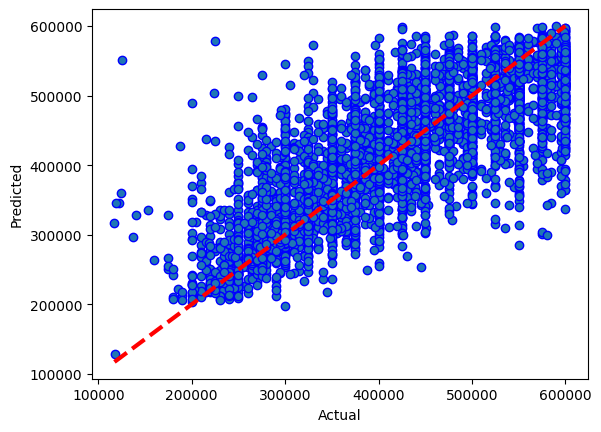

In [22]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(y_test, model.predict(X_test), edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_ylabel('Predicted')
ax.set_xlabel('Actual')
#ax.title.set_text(f'CV Chosen best option ({calculated_best_pipe[1]})')
plt.show()

In [23]:
from datetime import datetime

results = {
    'Score': score,
    'R square Accuracy': R2,
    'Mean Absolute Error Accuracy': MAE,
    'Mean Squared Error Accuracy': MSE,
    'Root Mean Squared Error': RMSE,
    'Training Time': average_time,
    'random_state': RANDOM_STATE,
    'date': str(datetime.now())
}
import json

results_filename = '../../results/results.json'

with open(results_filename) as f:
    raw_audit = f.read()
results_json = json.loads(raw_audit)

results_json[f'{ALGORITHM} - {ALGORITHM_DETAIL} (v{VERSION})'.lower()] = results

with open(results_filename, 'w') as file:
    file.write(json.dumps(results_json, indent=4, sort_keys=True))
